### Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from models import *
import matplotlib.pyplot as plt

# Import data

In [2]:
# read data
df = pd.read_csv('data/data.csv')

# Prepare data for training

In [3]:
feature_cols = [col for col in df.columns if col not in ['timestamp','ticker','target']]
df_norm = df.copy(deep=True)
df_norm = df_norm.dropna(subset=feature_cols) # should not drop any rows

df_norm['timestamp'] = pd.to_datetime(df_norm['timestamp'])

# drop data from 2025
df_norm = df_norm[df_norm['timestamp'] < '2025-01-01']

# normalize inputs
X_values = df_norm[feature_cols].values.astype('float64')

# # simple normalization: subtract mean, divide std
# X_mean, X_std = X_values.mean(axis=0), X_values.std(axis=0)
# X_values = (X_values - X_mean) / (X_std + 1e-8) # adding a small epsilon to avoid division by zero

y_values = df_norm['target'].values.astype('float64')

periods = { '20' : '2020-01-01', 
            '21' : '2021-01-01', 
            '22' : '2022-01-01', 
            '23' : '2023-01-01' 
            } # year used for validation i.e. 2020-01-01 will use 2001-2019 for training and 2020 for validation

X_train, y_train = {}, {}
X_val, y_val = {}, {}
X_test, y_test = {}, {}
X_scalars, y_scalars = {}, {}


for name, period in periods.items():
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    assert (df_norm.loc[tr_mask, 'timestamp'].max() <
        df_norm.loc[va_mask, 'timestamp'].min()), "train leaks into val"

    assert (df_norm.loc[va_mask, 'timestamp'].max() <
            df_norm.loc[te_mask, 'timestamp'].min()), "val leaks into test"

    X_tr, y_tr = X_values[tr_mask], y_values[tr_mask]
    X_va, y_va = X_values[va_mask], y_values[va_mask]
    X_te, y_te = X_values[te_mask], y_values[te_mask]

    X_scalars[name], y_scalars[name] = StandardScaler(), StandardScaler()

    X_scalars[name].fit(X_tr)
    X_train[name] = X_scalars[name].transform(X_tr)
    X_val[name] = X_scalars[name].transform(X_va)
    X_test[name] = X_scalars[name].transform(X_te)

    # ignoring the target normalization
    # y_scalars[name].fit(y_tr.reshape(-1, 1))
    # y_train[name] = y_scalars[name].transform(y_tr.reshape(-1, 1))
    # y_val[name] = y_scalars[name].transform(y_va.reshape(-1, 1))
    # y_test[name] = y_scalars[name].transform(y_te.reshape(-1, 1))

    y_train[name] = y_tr.reshape(-1, 1)
    y_val[name] = y_va.reshape(-1, 1)
    y_test[name] = y_te.reshape(-1, 1)


In [4]:
# moving to metal or CUDA GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

# general hyperparameters
# input_dim = x_train_mlp.shape[1]
hidden_depth = 2 # only hidden, excluding in- and output layers
hidden_width = 32 # int for all being equal width; list for different widths
learning_rate = 3e-4 # increased from 1e-3 as we have full batching
activation_fun = nn.ReLU # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU nn.Identity


# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 0.0 # 1e-3 currently 0 
lambda_l2 = 0.0 # 1e-3 0 because of weight decay


weight_decay = 1e-3
dropout = 0.2

# general parmeters
patience = 250
print_freq = 250
epochs = 500
batch_size = 5096 # adjust to your GPU memory


Using device: mps


# Train the model

In [5]:
best_models = {}
history = {}
models = {}

for name, period in periods.items():
    np.random.seed(42)
    torch.manual_seed(42)
    print(f"Training model for year '{name}...")
    input_dim = X_train[name].shape[1]
    models[name] = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
    optimizer = torch.optim.AdamW(models[name].parameters(), weight_decay=weight_decay, lr=learning_rate)
    train = MLPdataset(X_train[name], y_train[name])
    val = MLPdataset(X_val[name], y_val[name])
    best_models[name], history[name] = train_mlp(train,          
                                                val,
                                                models[name],
                                                criterion,
                                                epochs,
                                                patience,
                                                print_freq,
                                                device,
                                                optimizer,
                                                lambda_l1=lambda_l1,
                                                lambda_l2=lambda_l2,
                                                batch_size=batch_size,
                                                shuffle_train=True,
                                                shuffle_val=False,
                                                save_path=f'models/mlp_y{name}_l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth')

Training model for year '20...
Epoch 250/500  - Train Loss: 2.47464E-02  - Val Loss: 2.04414E-02
Early stopping at epoch 314
Best val loss: 2.02744E-02
Model saved to models/mlp_y20_l10.0_l20.001_drop0.2_lr0.0003_w32_d2.pth
Training model for year '21...
Epoch 250/500  - Train Loss: 2.45742E-02  - Val Loss: 1.27489E-02
Early stopping at epoch 285
Best val loss: 1.24886E-02
Model saved to models/mlp_y21_l10.0_l20.001_drop0.2_lr0.0003_w32_d2.pth
Training model for year '22...
Epoch 250/500  - Train Loss: 2.43815E-02  - Val Loss: 8.41290E-02
Epoch 500/500  - Train Loss: 2.37942E-02  - Val Loss: 8.43473E-02
Best val loss: 8.36762E-02
Model saved to models/mlp_y22_l10.0_l20.001_drop0.2_lr0.0003_w32_d2.pth
Training model for year '23...
Epoch 250/500  - Train Loss: 2.61055E-02  - Val Loss: 1.32208E-02
Early stopping at epoch 445
Best val loss: 1.31177E-02
Model saved to models/mlp_y23_l10.0_l20.001_drop0.2_lr0.0003_w32_d2.pth


In [6]:
# best_models = {}
# history = {}
# models = {}

# for name, period in periods.items():
#     np.random.seed(42)
#     torch.manual_seed(42)
#     print(f"Training model for period {name}...")
#     input_dim = X_train[name].shape[1]
#     models[name] = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
#     optimizer = torch.optim.AdamW(models[name].parameters(), weight_decay=weight_decay, lr=learning_rate)
#     train = MLPdataset(X_train[name], y_train[name])
#     val = MLPdataset(X_val[name], y_val[name])
#     best_models[name], history[name] = train_mlp(train,          
#                                                  val,
#                                                  models[name],
#                                                  criterion,
#                                                  epochs,
#                                                  patience,
#                                                  print_freq,
#                                                  device,
#                                                  optimizer,
#                                                  lambda_l1=lambda_l1,
#                                                  lambda_l2=lambda_l2,
#                                                  batch_size=batch_size,
#                                                  shuffle_train=True,
#                                                  shuffle_val=False,
#                                                  save_path=f'models/mlp_model_{name}.pth')

# Graph the model

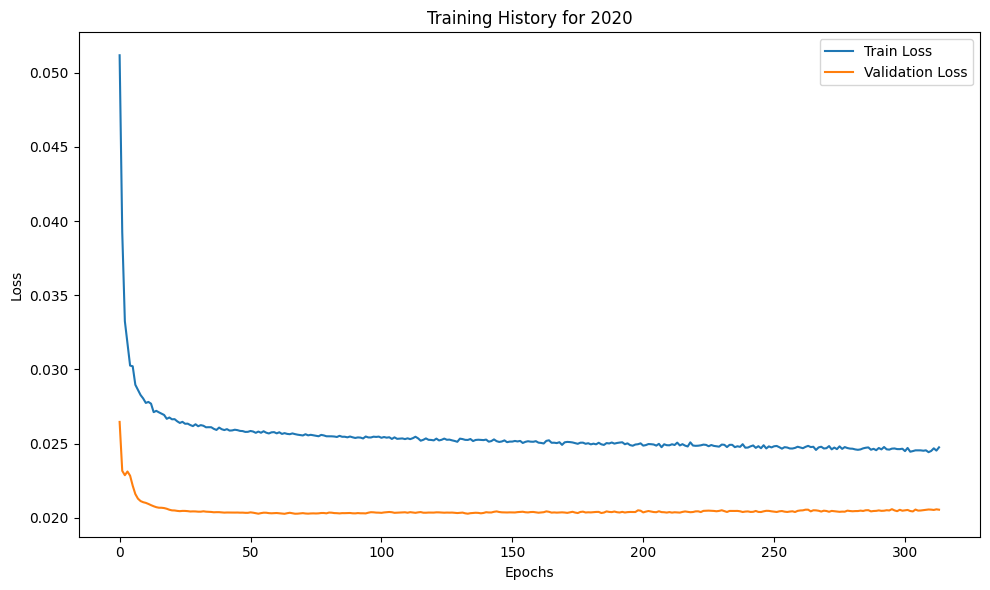

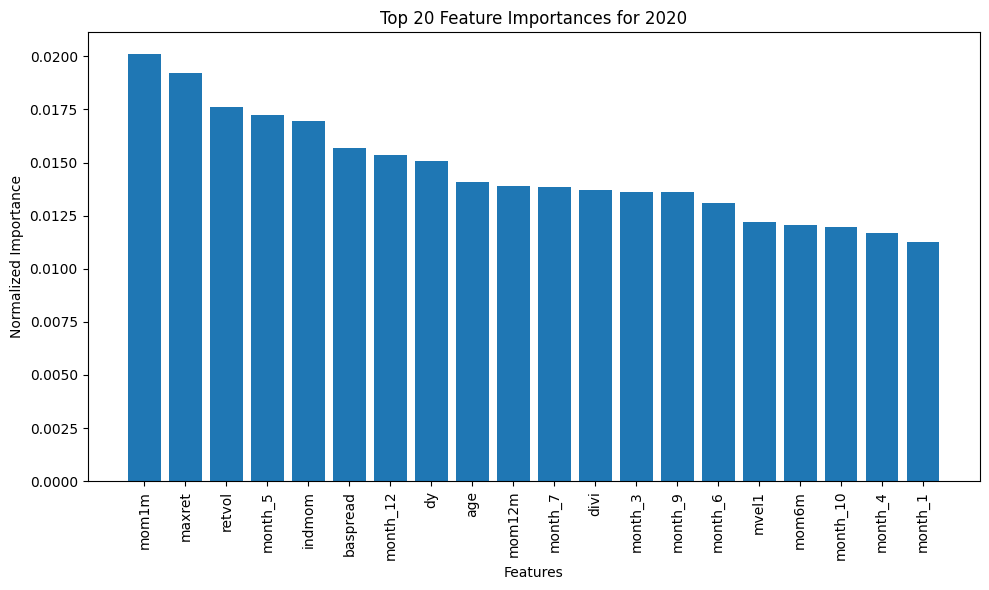

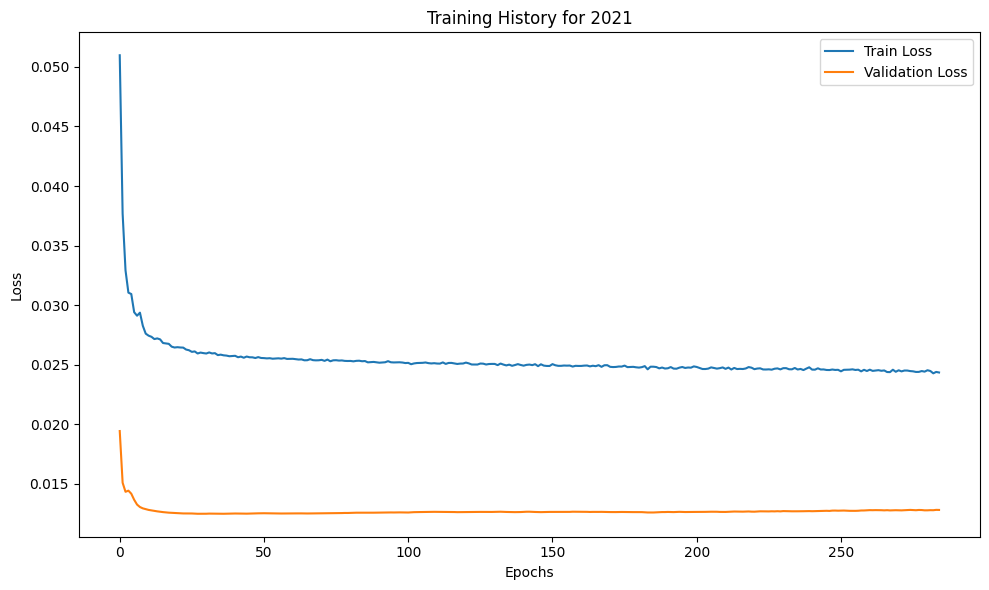

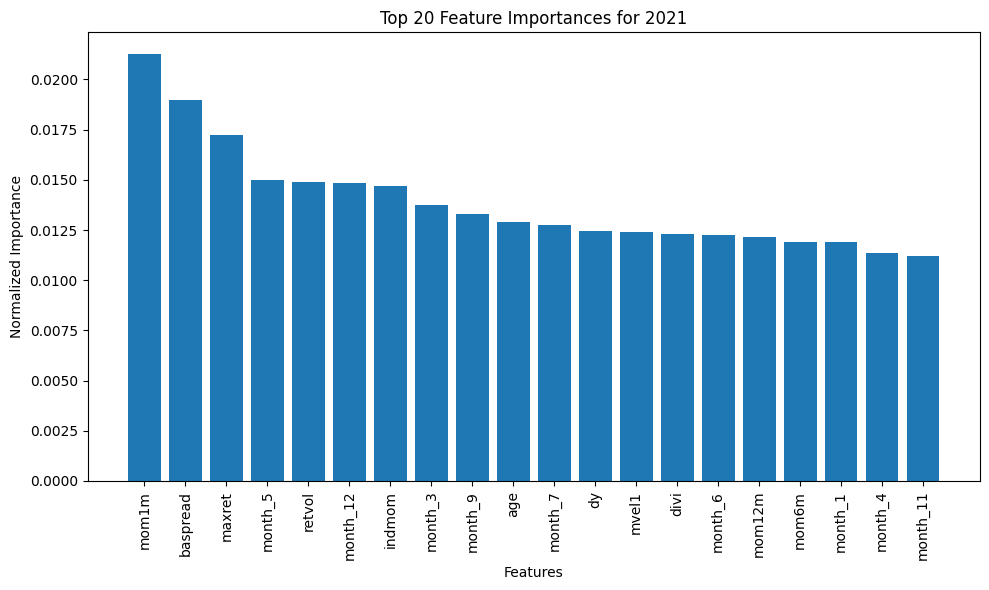

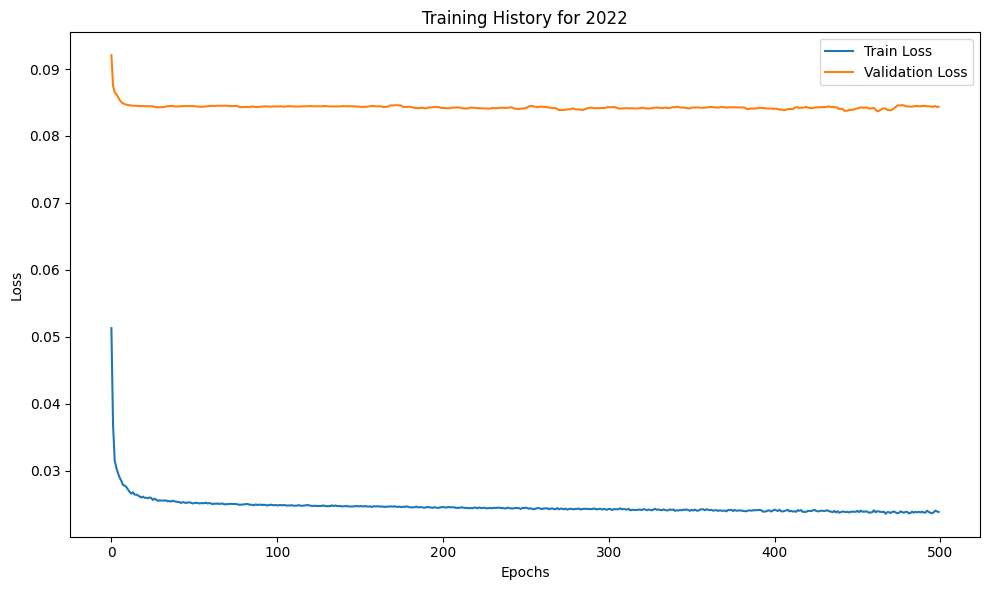

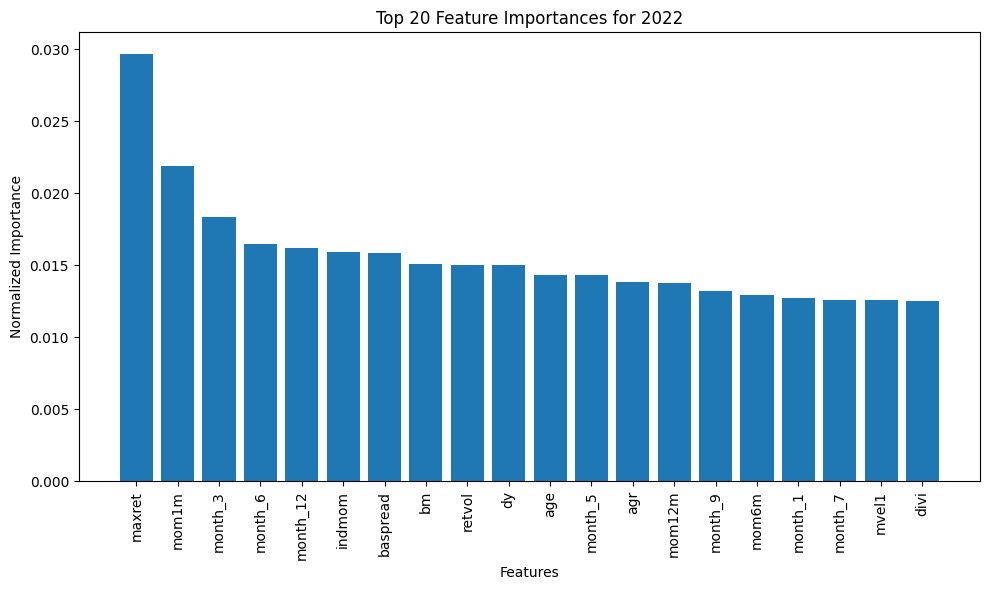

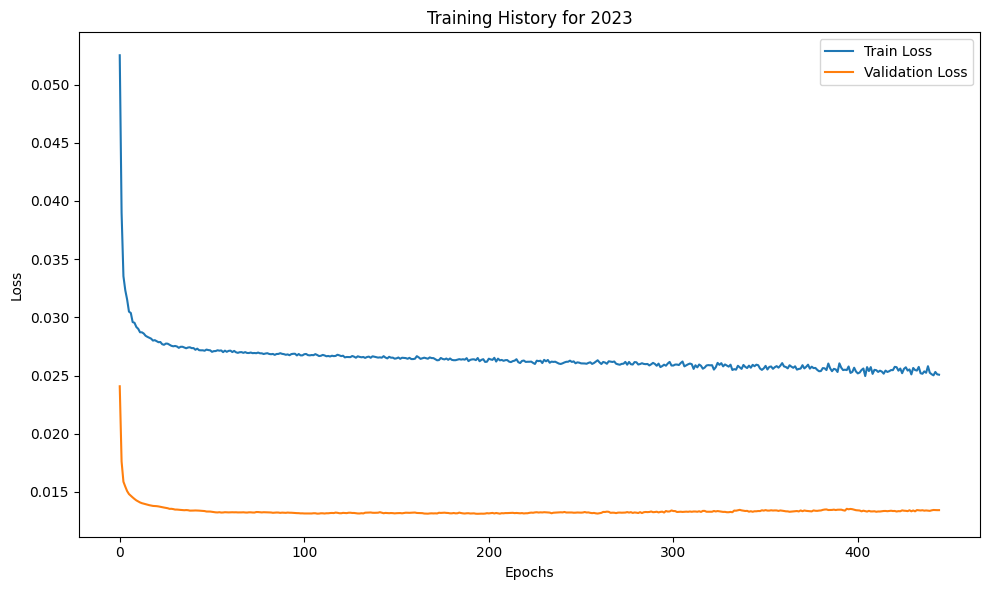

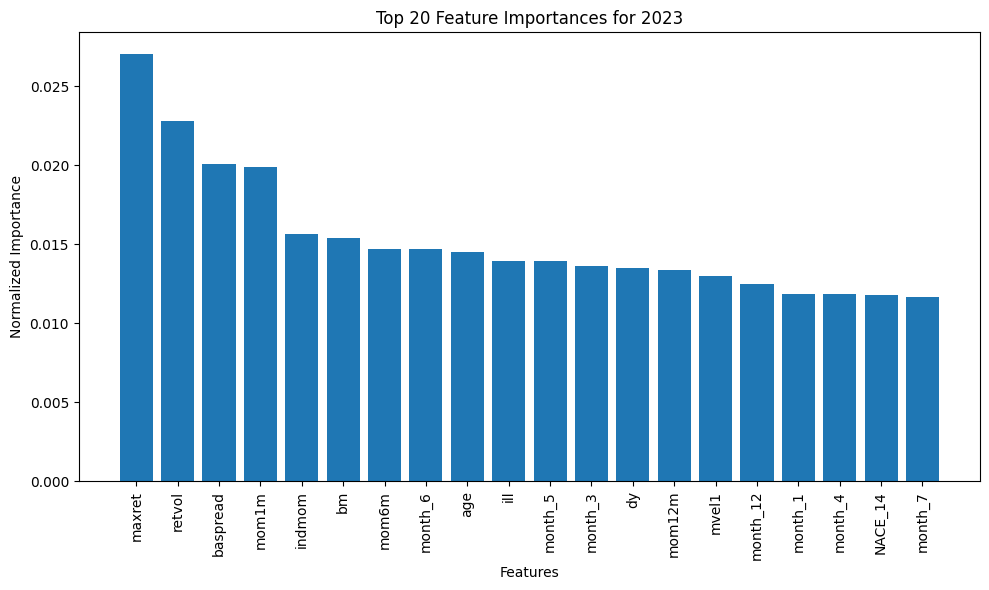

In [7]:
top_n = 20  # how many features to show

for name, period in periods.items():
    # plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history[name]['train_loss'], label='Train Loss')
    plt.plot(history[name]['val_loss'],   label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training History for 20{name}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # plot importance in best model
    best_model = best_models[name].eval()
    val_loader = DataLoader(MLPdataset(X_val[name], y_val[name]), batch_size=batch_size, shuffle=False)

    # --- COMMENTED OUT: drop boolean vars if you want ---
    # bool_vars = [c for c in feature_cols if c.startswith('NACE_') or c.startswith('month_')]
    # feature_cols = [c for c in feature_cols if c not in bool_vars]
    # ------------------------------------------------------

    # accumulate gradients
    n_features = len(feature_cols)
    feature_importance = torch.zeros(n_features).to(device)
    n_samples = 0

    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        batch_X.requires_grad_()
        outputs = best_model(batch_X)
        output_sum = outputs.sum()
        
        best_model.zero_grad()
        output_sum.backward()
        
        feature_importance += batch_X.grad.abs().sum(dim=0)
        n_samples += batch_X.size(0)

    feature_importance /= n_samples
    importance_np = feature_importance.cpu().detach().numpy()
    importance_norm = importance_np / importance_np.sum()

    # sort descending
    sorted_idx        = np.argsort(importance_norm)[::-1]
    sorted_importance = importance_norm[sorted_idx]
    sorted_features   = [feature_cols[i] for i in sorted_idx]

    # keep only top_n
    sorted_features = sorted_features[:top_n]
    sorted_importance = sorted_importance[:top_n]

    # bar chart of top features
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_features)), sorted_importance, align='center')
    plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Normalized Importance')
    plt.title(f'Top {top_n} Feature Importances for 20{name}')
    plt.tight_layout()
    plt.show()
    plt.close()

# Test hyperparameters

In [8]:
# training model with most data on multiple parameters
# geomspace for weight decay
weight_decay_space = [1e-4, 1e-3, 5e-3, 1e-2] # np.geomspace(1e-4, 1e-2, num=4)
dropout_space = [0.0, 0.1, 0.2, 0.3] # np.geomspace(0.0, 0.3, num=4)
learning_rate_space = [learning_rate] # np.geomspace(1e-4, 5e-3, num=4)
depth_space = [1, 2, 3]
width_space = [32, 64, 128]

best_models_23 = {}
history_23 = {}
models_23 = {}
year = '23'

for weight_decay in weight_decay_space:
    for dropout in dropout_space:
        for learning_rate in learning_rate_space:
            for hidden_depth in depth_space:
                for hidden_width in width_space:
                    np.random.seed(42)
                    torch.manual_seed(42)
                    print(f"Training model for year '{year} with weight_decay={weight_decay}, dropout={dropout}, learning_rate={learning_rate}, hidden_depth={hidden_depth}, hidden_width={hidden_width}...")
                    # Initialize the model
                    input_dim = X_train[year].shape[1]
                    name = f'l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                    models_23[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                    optimizer = torch.optim.AdamW(models_23[name].parameters(), weight_decay=weight_decay, lr=learning_rate)
                    train = MLPdataset(X_train[year], y_train[year])
                    val = MLPdataset(X_val[year], y_val[year])
                    best_models_23[name], history_23[name] = train_mlp(train,          
                                                    val,
                                                    models_23[name],
                                                    criterion,
                                                    epochs,
                                                    patience,
                                                    print_freq,
                                                    device,
                                                    optimizer,
                                                    lambda_l1=lambda_l1,
                                                    lambda_l2=lambda_l2,
                                                    batch_size=batch_size,
                                                    shuffle_train=True,
                                                    shuffle_val=False,
                                                    save_path=f'models/mlp_y23_l1{lambda_l1}_l2{weight_decay}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth')

Training model for year '23 with weight_decay=0.0001, dropout=0.0, learning_rate=0.0003, hidden_depth=1, hidden_width=32...
Epoch 250/500  - Train Loss: 2.41825E-02  - Val Loss: 1.86840E-02
Early stopping at epoch 276
Best val loss: 1.55034E-02
Model saved to models/mlp_y23_l10.0_l20.0001_drop0.0_lr0.0003_w32_d1.pth
Training model for year '23 with weight_decay=0.0001, dropout=0.0, learning_rate=0.0003, hidden_depth=1, hidden_width=64...
Epoch 250/500  - Train Loss: 2.26286E-02  - Val Loss: 1.99727E-02
Early stopping at epoch 278
Best val loss: 1.66661E-02
Model saved to models/mlp_y23_l10.0_l20.0001_drop0.0_lr0.0003_w64_d1.pth
Training model for year '23 with weight_decay=0.0001, dropout=0.0, learning_rate=0.0003, hidden_depth=1, hidden_width=128...
Epoch 250/500  - Train Loss: 2.06371E-02  - Val Loss: 1.82761E-02
Early stopping at epoch 297
Best val loss: 1.43564E-02
Model saved to models/mlp_y23_l10.0_l20.0001_drop0.0_lr0.0003_w128_d1.pth
Training model for year '23 with weight_deca